In [2]:
from nldg.utils import *
from nldg.rf import MaggingRF_PB
from adaXT.random_forest import RandomForest
from nldg.train_nn import *
from sklearn.preprocessing import StandardScaler

## GDRO

In [3]:
#dtr = gen_data_v2(n=1000)
#dtr = gen_data_v3(n=1000, setting=2)
#dtr = gen_data_v4(n_easy=500, n_hard=500)
#dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
dtr = gen_data_v6(n=1000, noise_std=0.5)
#dtr = gen_data_v7(n=1500)
#dtr = gen_data_v8(n=1500)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_train_sorted = scaler.fit_transform(Xtr_sorted)

lr = 0.01 # 0.01 for second setting
seed = 42
hd = [64, 64]
wd = 0.001
epochs=1500

model, bweights = train_model_GDRO(X_train, Ytr, Etr,
                                   lr_model=lr, hidden_dims=hd,
                                   seed=seed, weight_decay=wd, epochs=epochs)
preds_gdro = predict_GDRO(model, X_train_sorted)
fitted_gdro = predict_GDRO(model, X_train)

In [5]:
bweights

tensor([6.5036e-02, 9.3489e-01, 7.0079e-05])

In [7]:
model_default = train_model(X_train, Ytr,
                            lr=lr, hidden_dims=hd,
                            seed=seed, weight_decay=wd, epochs=epochs)
preds_default = predict_default(model_default, X_train_sorted)
fitted_default = predict_default(model_default, X_train)

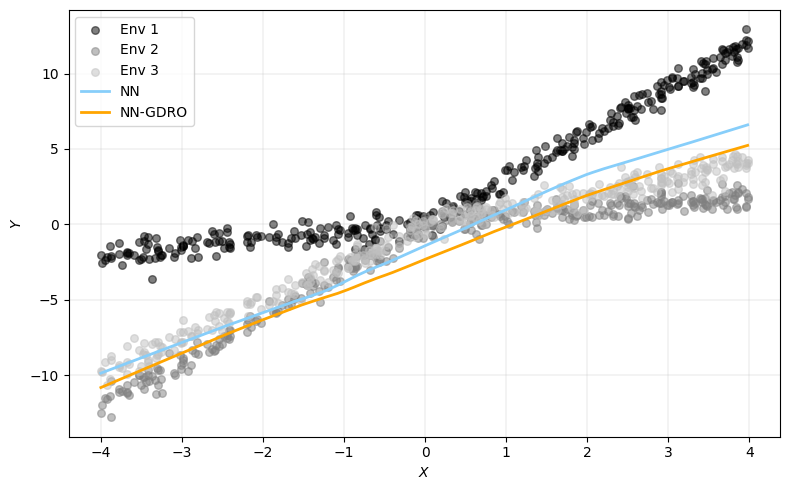

In [8]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_gdro"] = preds_gdro
dtr["fitted_default"] = preds_default

plot_dtr(dtr, gdro=True)

## Minimax Random Forest

In [9]:
dtr = gen_data_v6(n=1000, noise_std=0.5)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 30
random_state = 42

#### RF

In [10]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf, Etr, verbose=True)

Environment 0 MSE: 13.181806223909755
Environment 1 MSE: 5.985511984704188
Environment 2 MSE: 1.5098758314189895


np.float64(13.181806223909755)

#### MaggingRF

In [12]:
rf_magging = MaggingRF_PB(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 13.799106342585175
Environment 1 MSE: 5.739841349744984
Environment 2 MSE: 1.467714303165803


np.float64(13.799106342585175)

#### L-MMRF

In [13]:
rf_l_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="base",
)
rf_l_mmrf.fit(Xtr, Ytr, Etr)
fitted_l_mmrf = rf_l_mmrf.predict(Xtr)
preds_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_l_mmrf, Etr, verbose=True)

Environment 0 MSE: 10.414662511936335
Environment 1 MSE: 10.441653540963538
Environment 2 MSE: 4.478372893430537


np.float64(10.441653540963538)

#### Post-RF

In [11]:
rf.modify_predictions_trees(Etr)
fitted_post_rf = rf.predict(Xtr)
preds_post_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_post_rf, Etr, verbose=True)

Environment 0 MSE: 9.309802763463583
Environment 1 MSE: 9.143744040842693
Environment 2 MSE: 3.178406865435695


np.float64(9.309802763463583)

#### Post-L-MMRF

In [14]:
rf_l_mmrf.modify_predictions_trees(Etr)
fitted_post_l_mmrf = rf_l_mmrf.predict(Xtr)
preds_post_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_post_l_mmrf, Etr, verbose=True)

Environment 0 MSE: 9.260718733240607
Environment 1 MSE: 9.22042830582729
Environment 2 MSE: 3.249562407618683


np.float64(9.260718733240607)

#### G-DFS-MMRF

In [15]:
rf_g_dfs_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="fullopt",
)
rf_g_dfs_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xtr)
preds_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_g_dfs_mmrf, Etr, verbose=True)

Environment 0 MSE: 9.222840818221005
Environment 1 MSE: 9.237304983262112
Environment 2 MSE: 3.2602634840579383


np.float64(9.237304983262112)

#### G-MMRF

In [16]:
rf_g_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="adafullopt",
)
rf_g_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_mmrf = rf_g_mmrf.predict(Xtr)
preds_g_mmrf = rf_g_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_g_mmrf, Etr, verbose=True)

Environment 0 MSE: 9.244992395934702
Environment 1 MSE: 9.211313851196863
Environment 2 MSE: 3.2426584656802295


np.float64(9.244992395934702)

#### Plot

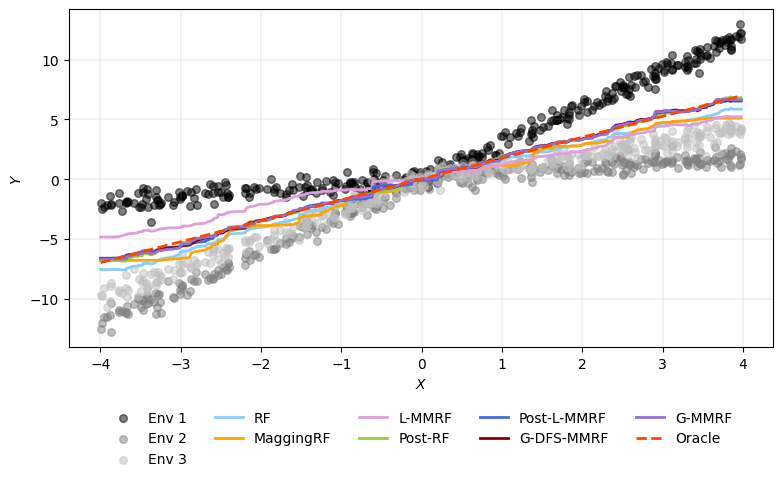

In [19]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_magging"] = preds_magging
dtr["fitted_l_mmrf"] = preds_l_mmrf
dtr["fitted_post_rf"] = preds_post_rf
dtr["fitted_post_l_mmrf"] = preds_post_l_mmrf
dtr["fitted_g_dfs_mmrf"] = preds_g_dfs_mmrf
dtr["fitted_g_mmrf"] = preds_g_mmrf

plot_dtr_all_methods(dtr, optfun=3)